In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
# Cryptarchia lottery function

def phi(f, alpha):
    return 1 - (1-f)**alpha

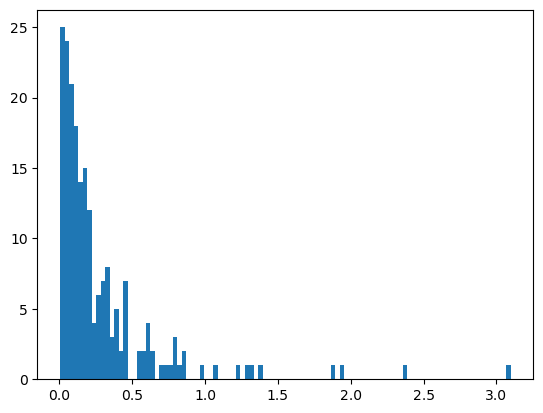

In [3]:
# Generate stake distribution
total_notes = 200

stake = np.random.pareto(5, total_notes)
_ = plt.hist(stake, bins=100)

In [4]:
# True Total Stake
true_stake = np.array(stake).sum()
true_stake

f = 1/30 # occupancy rate
T = int(10 * 2160 / f) # epoch length, 10k/f

In [5]:
epochs = 30
shock_size = [5, 10, 25, 50]
sims = 100
beta = 0.8

D_values = []
D_values_hi = []

def run_simulation(D_init, stake, sims, epochs, T):
    results = []
    for k in range(sims):
        D_ell = D_init
        D_sim = np.empty(epochs)
        
        for i in range(epochs):
            D_sim[i] = D_ell

            alpha = stake / D_ell
            p_lottery = phi(f, alpha)

            p_global_lottery = 1 - (1 - p_lottery).prod()
            p_global_occupied_slots = np.random.binomial(T, p_global_lottery)
            empirical_slot_activation_rate = p_global_occupied_slots / T
            
            #wins = np.random.uniform(0, 1, (T, len(stake))) < p_lottery
            #empirical_slot_activation_rate = np.count_nonzero(np.sum(wins, axis=1)) / T
            
            error = f - empirical_slot_activation_rate

            h = beta * (D_ell / f)
            D_ell = D_ell - h * error

        results.append(D_sim)
    
    return results

for shock in shock_size:

    # Low shock run
    D_init_low = true_stake - (true_stake * shock / 100)
    D_values.append(run_simulation(D_init_low, stake, sims, epochs, T))
    print(f"Low shock {shock}% done.")

    # High shock run
    D_init_hi = true_stake + (true_stake * shock / 100)
    D_values_hi.append(run_simulation(D_init_hi, stake, sims, epochs, T))
    print(f"High shock {shock}% done.")

Low shock 5% done.
High shock 5% done.
Low shock 10% done.
High shock 10% done.
Low shock 25% done.
High shock 25% done.
Low shock 50% done.
High shock 50% done.


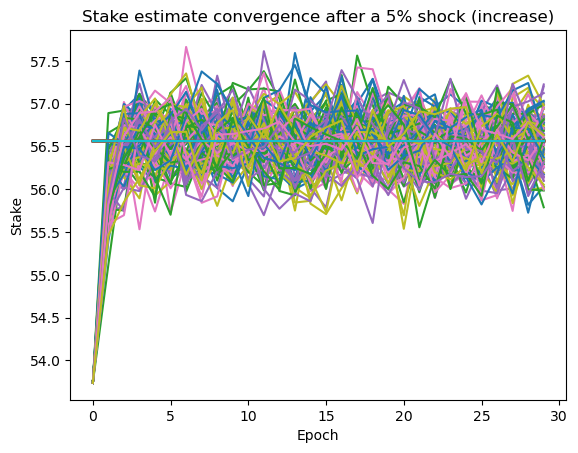

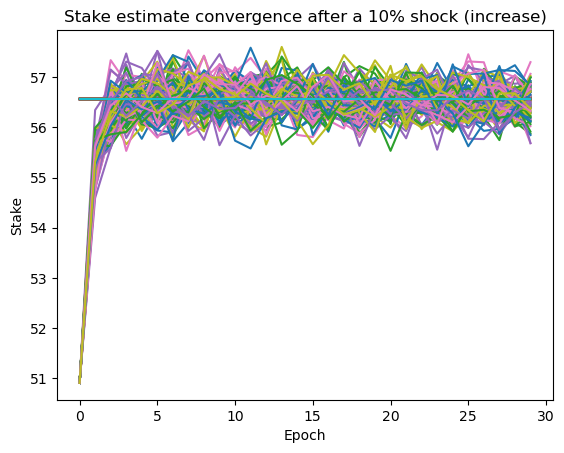

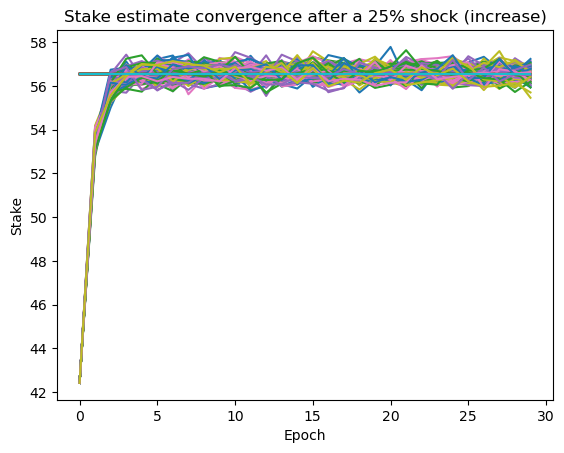

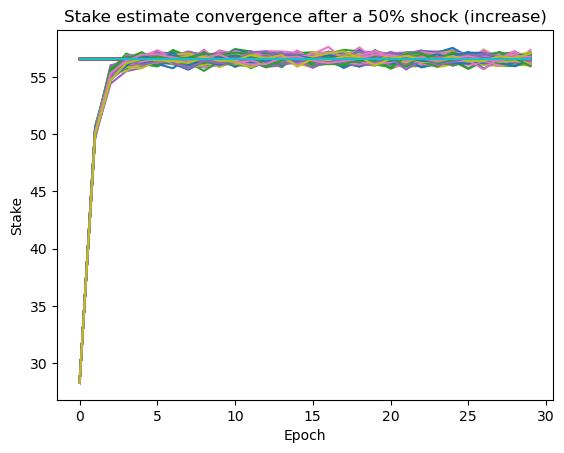

In [6]:
# plot convergence for lower estimates
for j in range(0, len(shock_size)):
    for k in range(0, sims):
        plt.plot(range(0, epochs), D_values[j][k])
        plt.plot(range(0, epochs), np.full_like(range(0, epochs), true_stake, dtype=float))
        plt.xlabel("Epoch")
        plt.ylabel("Stake")
        plt.title(f"Stake estimate convergence after a {shock_size[j]}% shock (increase)")
    plt.show()

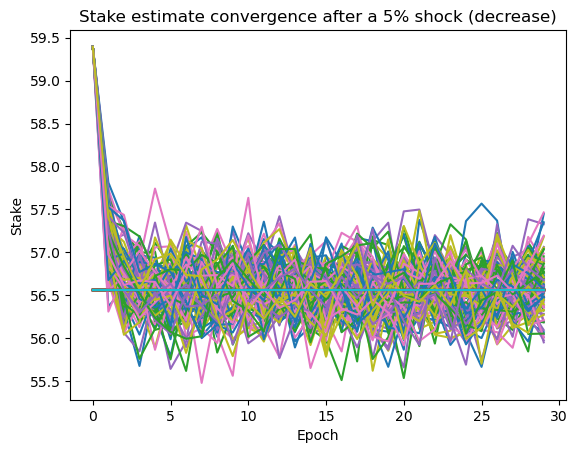

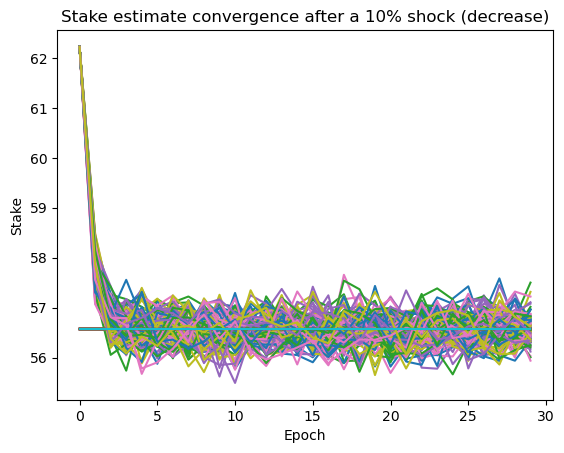

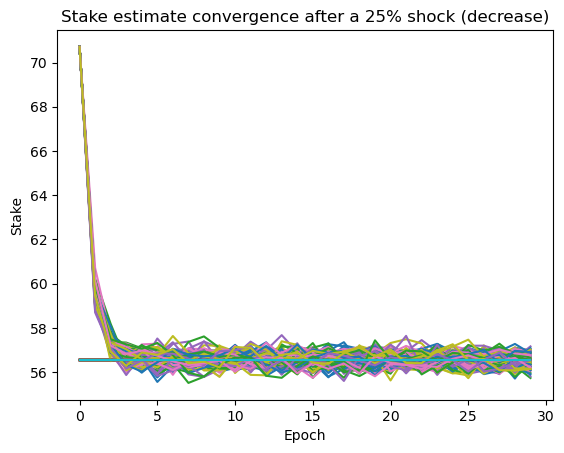

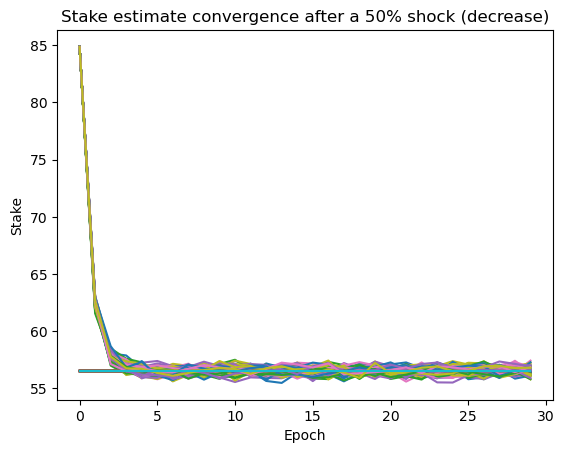

In [7]:
# plot convergence for higher estimates
for j in range(0, len(shock_size)):
    for k in range(0, sims):
        plt.plot(range(0, epochs), D_values_hi[j][k])
        plt.plot(range(0, epochs), np.full_like(range(0, epochs), true_stake, dtype=float))
        plt.xlabel("Epoch")
        plt.ylabel("Stake")
        plt.title(f"Stake estimate convergence after a {shock_size[j]}% shock (decrease)")
    plt.show()

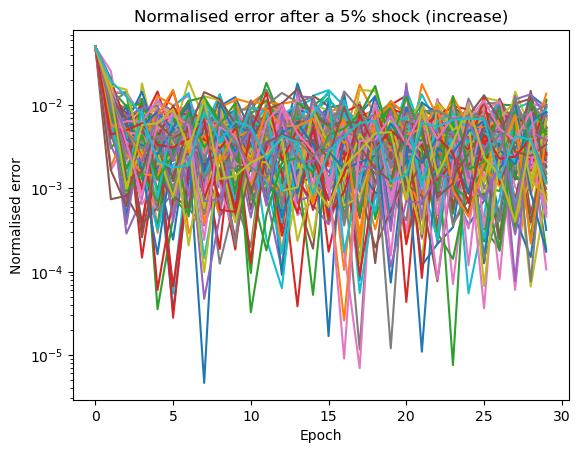

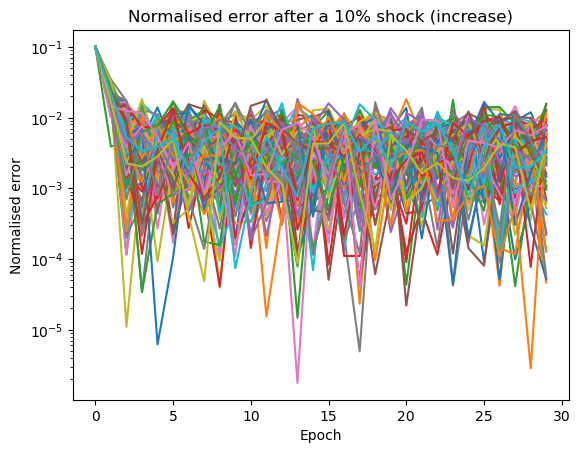

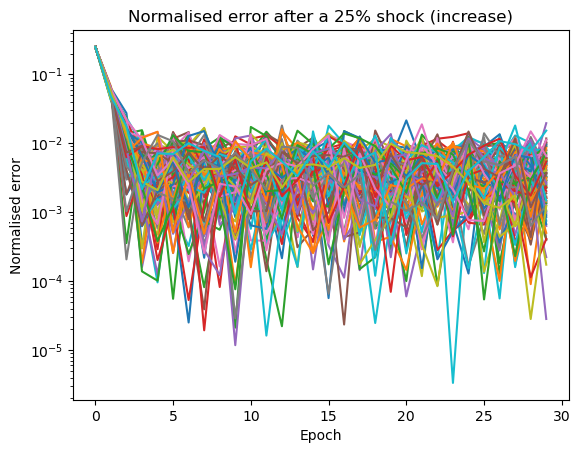

In [8]:
# plot error for lower estimates
for j in range(0, len(shock_size)):
    for k in range(0, sims):
        plt.plot(range(0, epochs), np.abs((D_values[j][k] - true_stake) / true_stake))
        plt.xlabel("Epoch")
        plt.ylabel("Normalised error")
        plt.yscale('log')
        plt.title(f"Normalised error after a {shock_size[j]}% shock (increase)")
    plt.show()

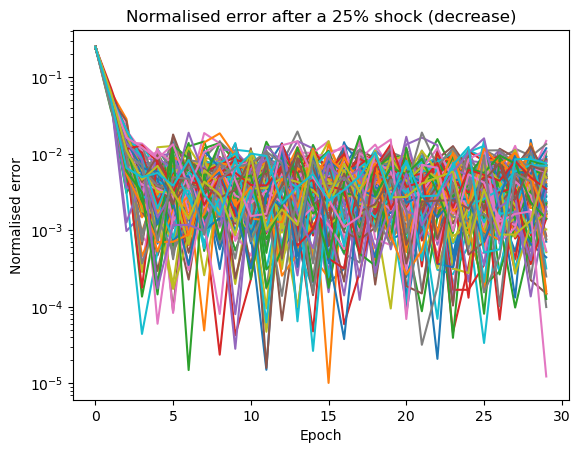

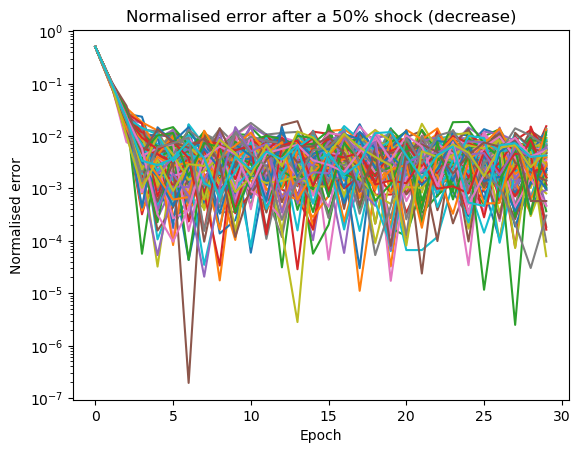

In [9]:
# plot error for higher estimates
for j in range(0, len(shock_size)):
    for k in range(0, sims):
        plt.plot(range(0, epochs), np.abs((D_values_hi[j][k] - true_stake) / true_stake))
        plt.xlabel("Epoch")
        plt.ylabel("Normalised error")
        plt.yscale('log')
        plt.title(f"Normalised error after a {shock_size[j]}% shock (decrease)")
    plt.show()

In [202]:
%%time
f=0.8
epochs = 30
betas = np.linspace(0.8, 1.2 * 2*f/((1-f)*np.log(1 / (1-f))), 5)
sims = 10000

D_values = []

def run_simulation_beta(D_init, stake, sims, epochs, T, beta):
    results = []
    for k in range(sims):
        D_ell = D_init
        D_sim = np.empty(epochs)
        
        for i in range(epochs):
            D_sim[i] = D_ell

            alpha = stake / D_ell
            p_lottery = phi(f, alpha)

            p_global_lottery = 1 - (1 - p_lottery).prod()
            p_global_occupied_slots = np.random.binomial(T, p_global_lottery)
            empirical_slot_activation_rate = p_global_occupied_slots / T
            
            #wins = np.random.uniform(0, 1, (T, len(stake))) < p_lottery
            #empirical_slot_activation_rate = np.count_nonzero(np.sum(wins, axis=1)) / T
            
            error = f - empirical_slot_activation_rate

            h = beta * (D_ell / f)
            D_ell = D_ell - h * error

        results.append(D_sim)
    
    return results

for beta in betas:
    D_init_low = true_stake - (true_stake * 50 / 100)
    D_values.append(run_simulation_beta(true_stake * 0.9, stake, sims, epochs, T, beta))

CPU times: user 6.81 s, sys: 15.1 ms, total: 6.83 s
Wall time: 6.83 s


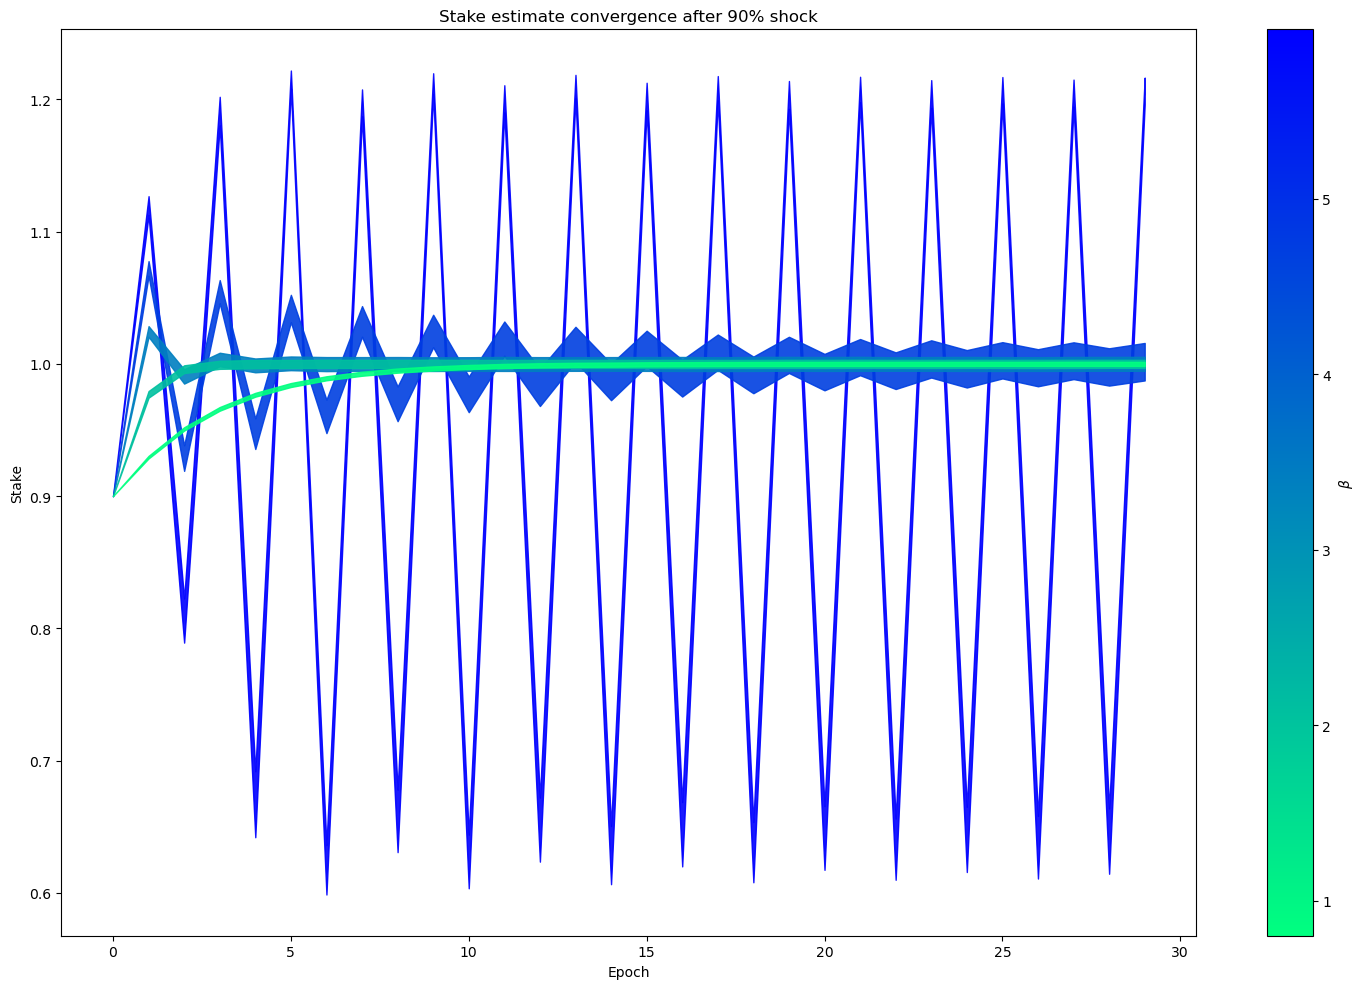

In [203]:
# plot convergence for betas using subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

# Handle case where there's only one beta (axes won't be an array)
axes = [axes]

#axes[0].plot(range(epochs), np.full_like(range(epochs), 1, dtype=float))

# Create a colormap and normalization for the colorbar
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Set up colormap and normalization
cmap = plt.cm.winter_r
norm = Normalize(vmin=min(betas), vmax=max(betas))

for j in reversed(range(len(betas))):
    for k in range(sims):
        if True:
            kwargs = {"label": f"beta={betas[j]:.2f}"}
        else:
            kwargs = {}
    
    D_min = np.percentile(np.array(D_values[j]), 1, axis=0) / true_stake
    D_max = np.percentile(np.array(D_values[j]), 99, axis=0) / true_stake

    # D_max = np.array(D_values[j]).max(axis=0) / true_stake
    
    # Use the normalized beta value to get color
    color = cmap(norm(betas[j]))
    # axes[0].plot(range(epochs), D_min, c=color, lw=0.5)
    # axes[0].plot(range(epochs), D_max, c=color, lw=0.5)
    axes[0].fill_between(range(epochs), D_min, D_max, color=color, alpha=0.9, label=f"beta={betas[j]:.2f}")
    
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Stake")

plt.title(f"Stake estimate convergence after {100 * D_values[0][0][0] / true_stake:.0f}% shock")
plt.tight_layout()

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for older matplotlib versions

# Specify the axes explicitly
plt.colorbar(sm, ax=axes[0], label='$\\beta$')  # <-- Added ax=axes[0]

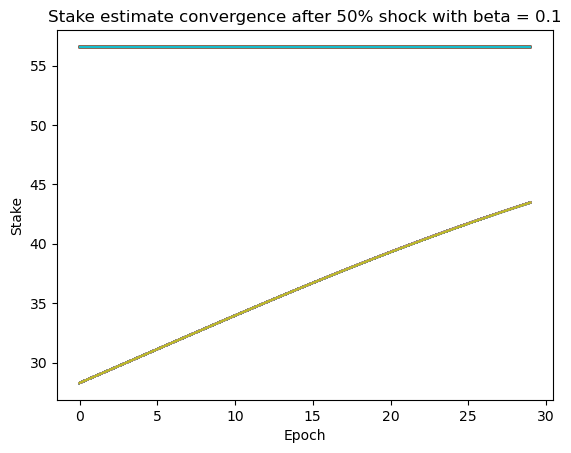

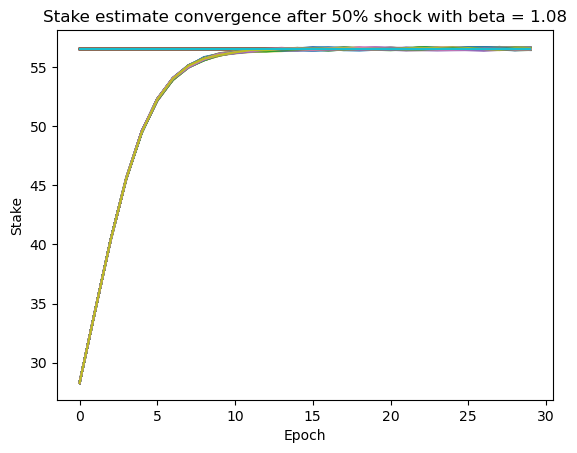

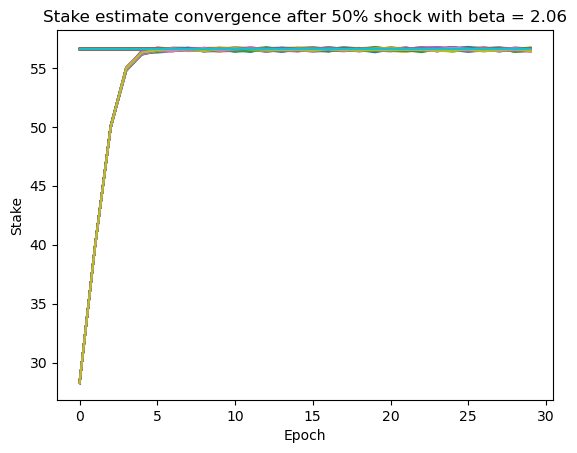

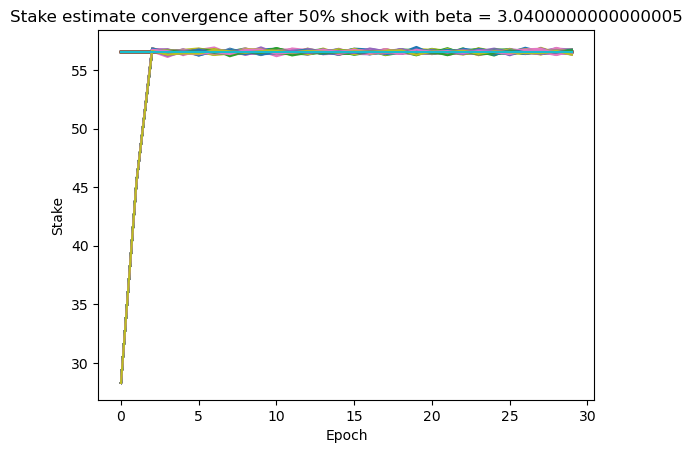

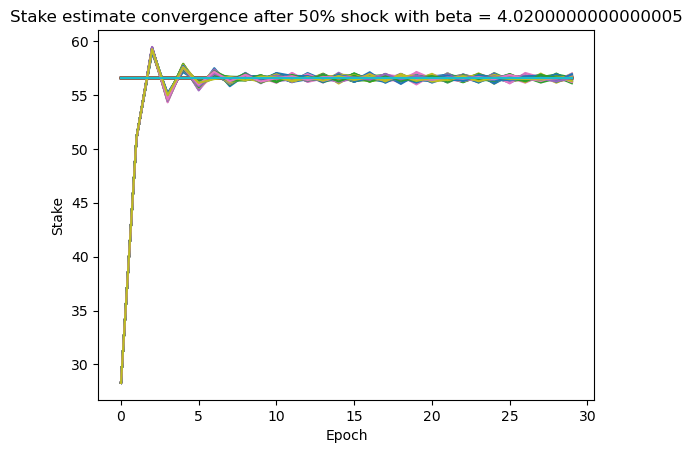

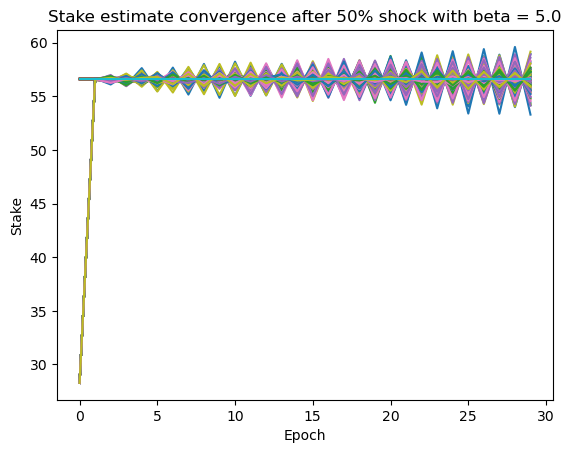

In [22]:
# plot convergence for betas
for j in range(0, len(betas)):
    for k in range(0, sims):
        plt.plot(range(0, epochs), D_values[j][k])
        plt.plot(range(0, epochs), np.full_like(range(0, epochs), true_stake, dtype=float))
        plt.xlabel("Epoch")
        plt.ylabel("Stake")
        plt.title(f"Stake estimate convergence after 50% shock with beta = {betas[j]}")
    plt.show()

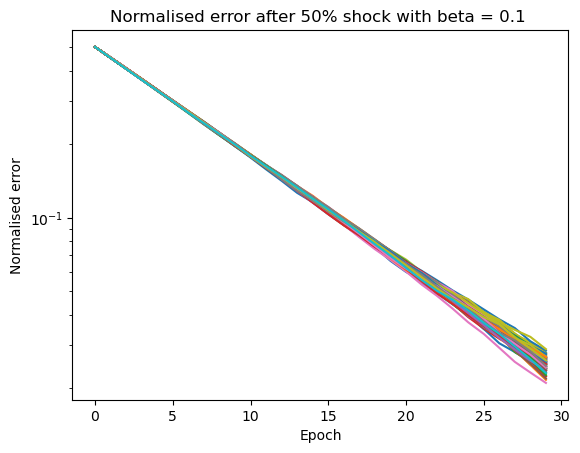

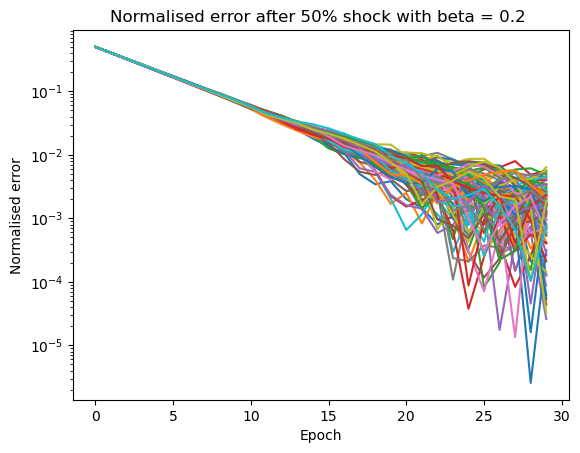

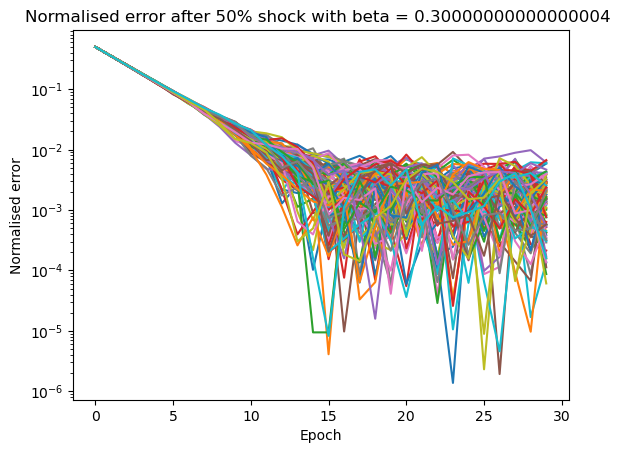

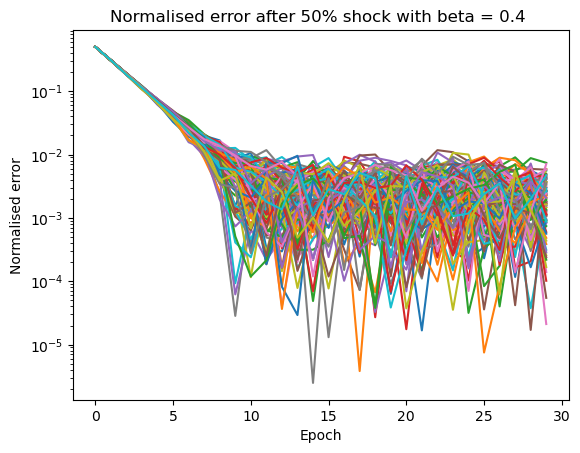

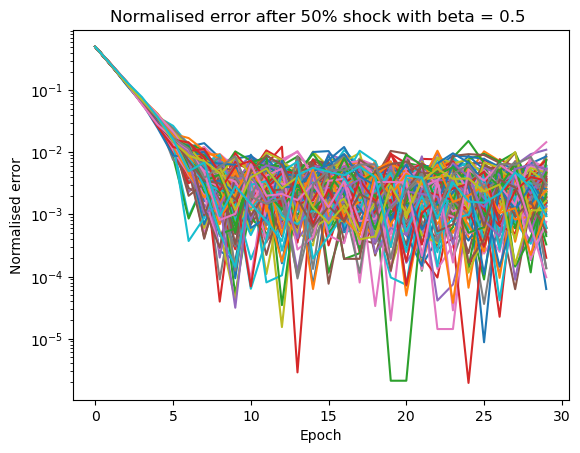

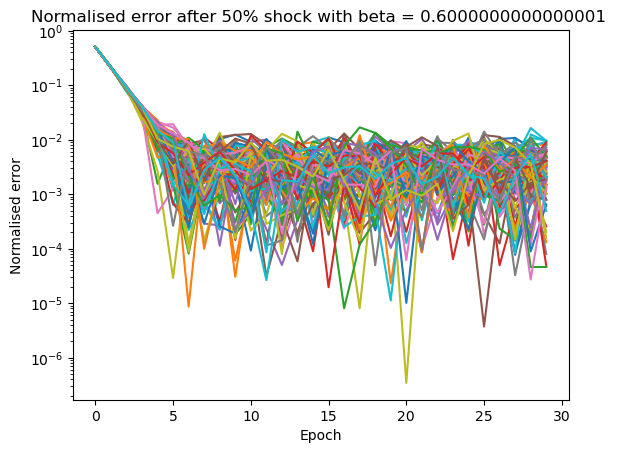

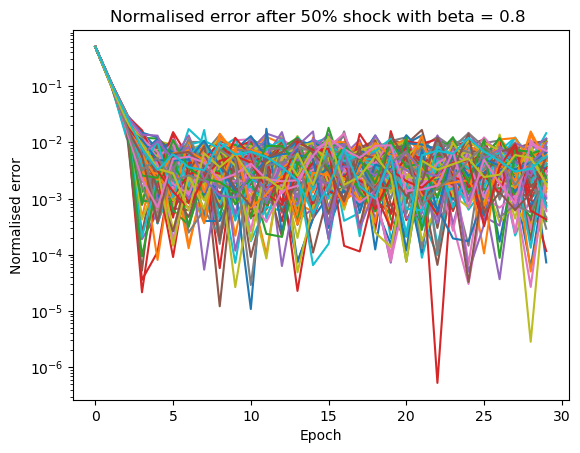

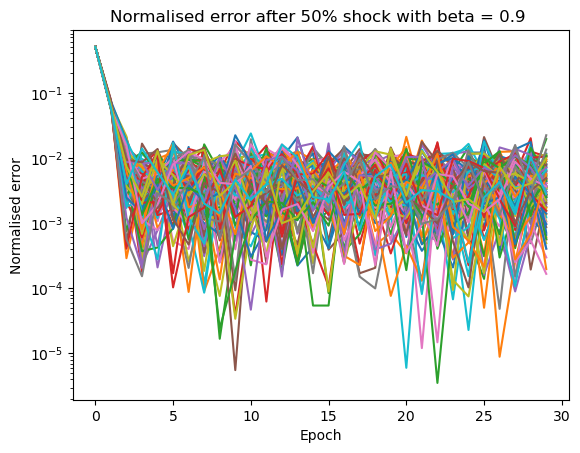

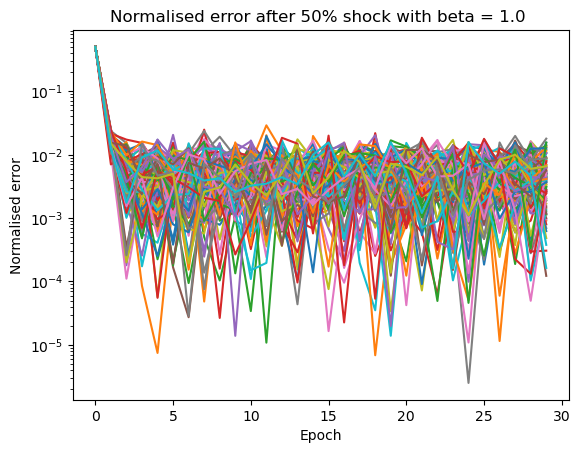

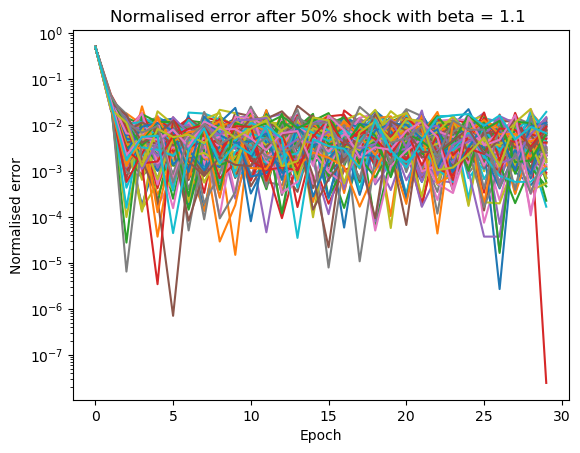

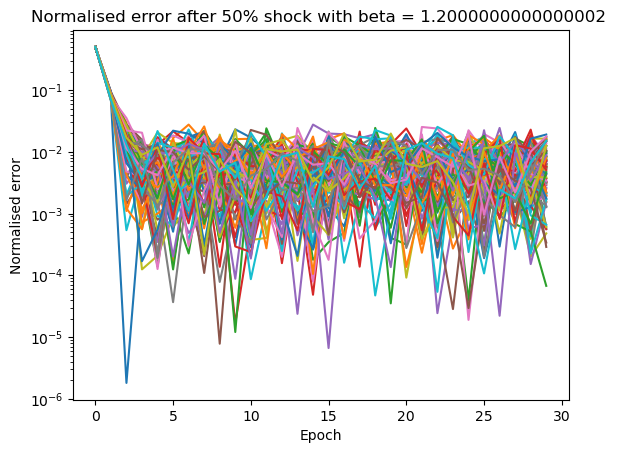

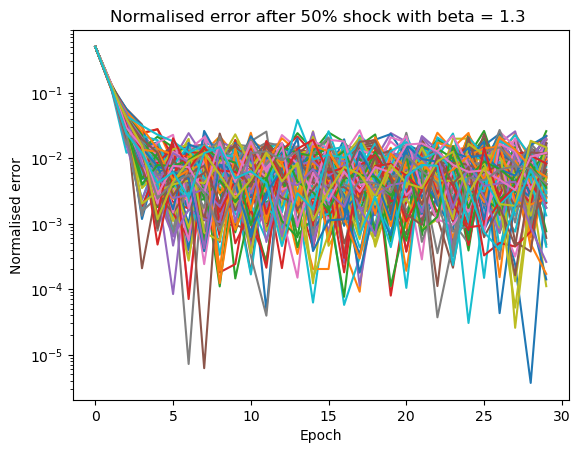

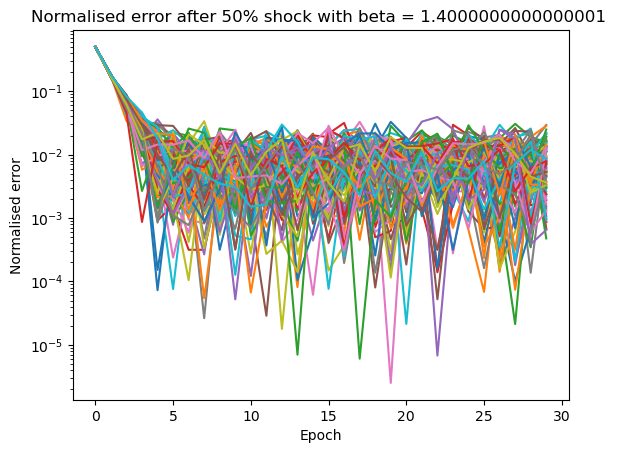

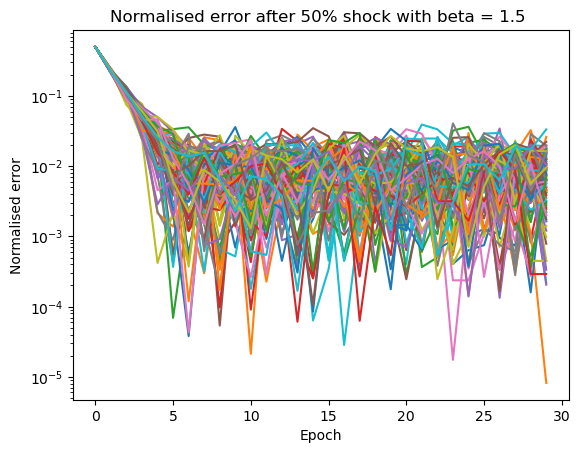

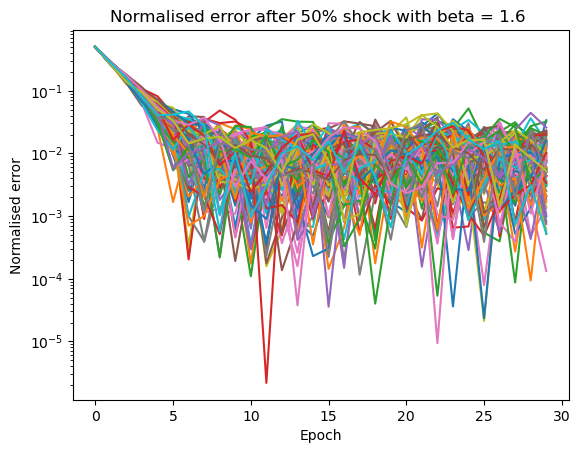

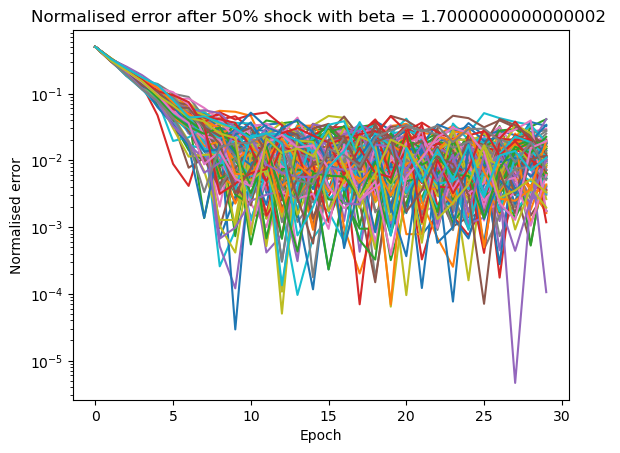

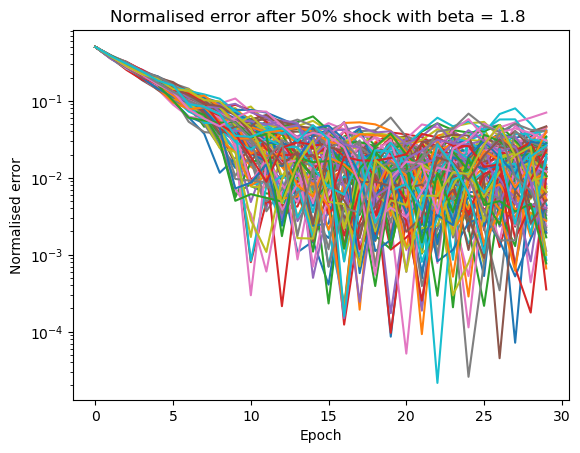

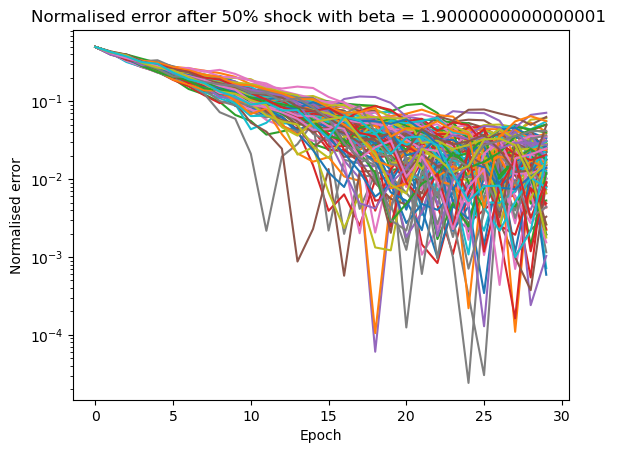

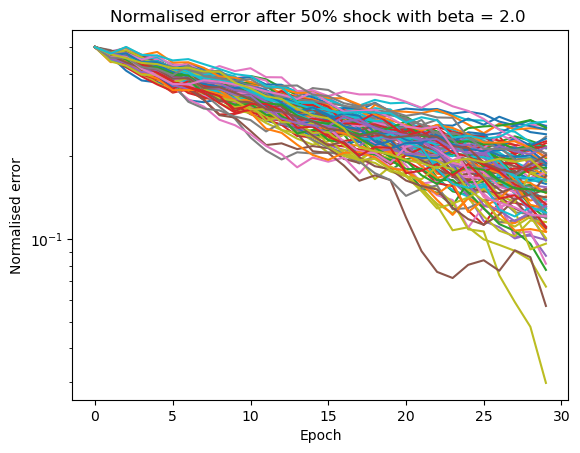

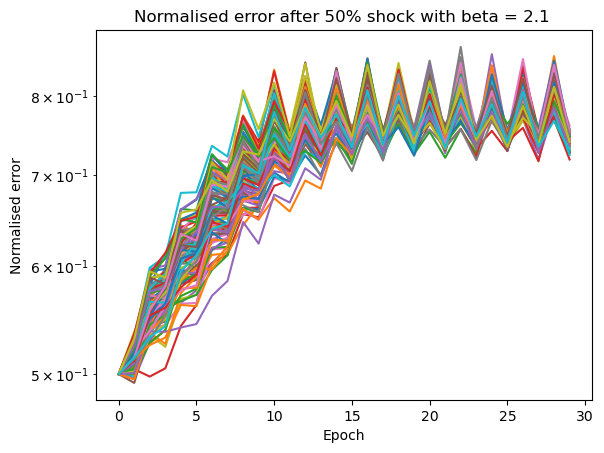

In [12]:
# plot error for betas
for j in range(0, len(betas)):
    for k in range(0, sims):
        plt.plot(range(0, epochs), np.abs((D_values[j][k] - true_stake) / true_stake))
        plt.xlabel("Epoch")
        plt.ylabel("Normalised error")
        plt.yscale('log')
        plt.title(f"Normalised error after 50% shock with beta = {betas[j]} ")
    plt.show()